# Spaceship Titanic Kaggle Competition

![spaceship](./img/798114.jpg)
# 1. Frame the problem and look at the big picture
*Define the objective in business terms.
How will your solution be used?
What are the current solutions/workarounds (if any)?
How should you frame this problem (supervised/unsupervised, online/offline, etc.)?
How should performance be measured?
Is the performance measure aligned with the business objective?
What would be the minimum performance needed to reach the business objectives?
What are comparable problems? Can you reuse experience or tools?
Is human expertise available?
How would you solve the problem manually?
List the assumptions you (or others) have made so far.
Verify assumptions if possible.*

We first found the Titanic dataset and found it pretty interesting, but a bit unoriginal. We then explored the kaggle competions further and found this spin on the classic dataset. We deemed this Spaceship Titanic would give us a fair challenge on our machine learning abilities, while not being too difficult.

This dataset is purely fictional and doesn't provide much in terms of usability. Still, we believed that picking a task that is fun to work with, will produce the best results.

# 2. Get the data
*List the data you need and how much you need.
Find and document where you can get that data.
Check how much space it will take.
Check legal obligations, and get authorization if necessary.
Get access authorizations.
Create a workspace (with enough storage space).
Get the data.
Convert the data to a format you can easily manipulate (without changing the data itself).
Ensure sensitive information is deleted or protected (e.g., anonymized).
Check the size and type of data (time series, sample, geographical, etc.).
Create a test set, put it aside, and never look at it (no data snooping!).*

## Setup

In [132]:
# Imports
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time
from matplotlib import pyplot

# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.utils import resample
from sklearn import model_selection

# Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC as svc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier

In [133]:
# Saving train and test set to dataframe
train = pd.read_csv(r"DATA\train.csv")
test = pd.read_csv(r"DATA\test.csv")

In [134]:
# Train preview
print("Train shape:", train.shape)
train.head()

Train shape: (8693, 14)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [135]:
# Test preview
print("Test shape:", test.shape)
test.head()

Test shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


The testset seems to contain 1/3 of total data, and the training set contains 2/3. Everything good so far.

# 3. Explore the data to gain insights
*Create a copy of the data for exploration (sampling it down to a manageable size if necessary).
Create a Jupyter notebook to keep a record of your data exploration.
Study each attribute and its characteristics:*
- *Name*
- *Type (categorical, int/float, bounded/unbounded, text, structured, etc.)*
- *% of missing values*
- *Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)*
- *Usefulness for the task*
- *Type of distribution (Gaussian, uniform, logarithmic, etc.)*.

*For supervised learning tasks, identify the target attribute(s).
Visualize the data.
Study the correlations between attributes.
Study how you would solve the problem manually.
Identify the promising transformations you may want to apply.
Identify extra data that would be useful
Document what you have learned.*

## Feature explanation
*From the competition description*
- >PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- >HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- >CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- >Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
- >Age - The age of the passenger.
- >VIP - Whether the passenger has paid for special VIP service during the voyage.
- >RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- >Name - The first and last names of the passenger.
- >Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [136]:
# Training set missing values
print(train.isna().sum())

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


In [137]:
# Calculating how many percent of the data that is missing
print("Missing from ",round(179/len(train)*100,1),"%. To ", round(217/len(train)*100,1), "%. Of almost every column in the training set.")

Missing from  2.1 %. To  2.5 %. Of almost every column in the training set.


In [138]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


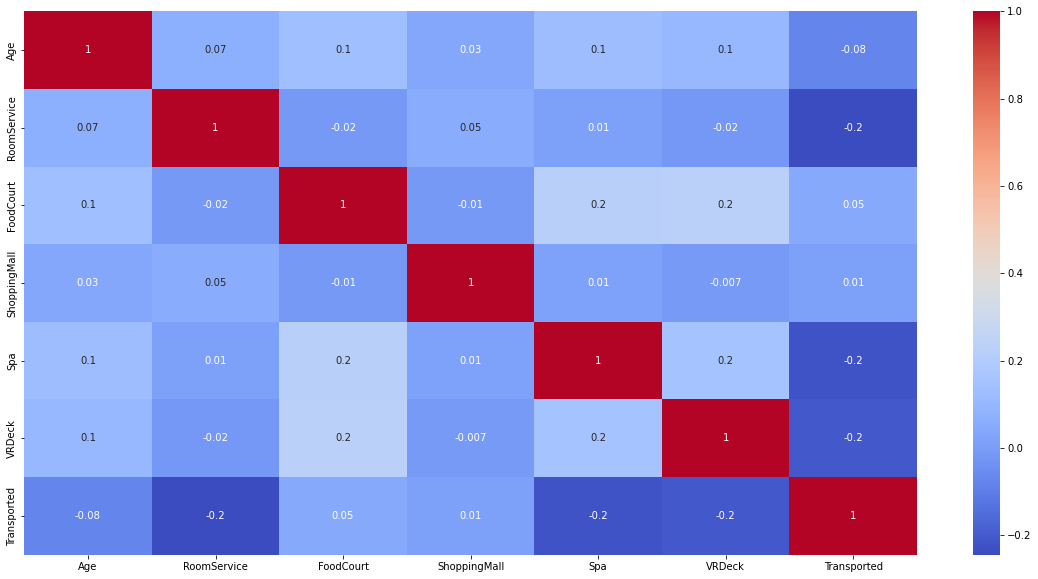

In [139]:
plt.figure(figsize=(20,10))
corrMatrix = train.corr()
sns.heatmap(corrMatrix, annot=True, cmap='coolwarm', fmt='.1g')
plt.show()

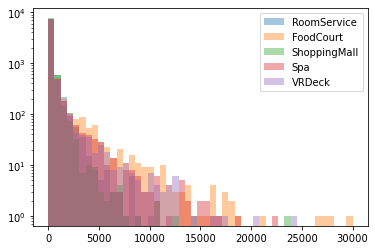

In [140]:
bins = np.linspace(0, 30000, 50)

plt.hist(train.RoomService, bins, alpha=0.4, label='RoomService')
plt.hist(train.FoodCourt, bins, alpha=0.4, label='FoodCourt')
plt.hist(train.ShoppingMall, bins, alpha=0.4, label='ShoppingMall')
plt.hist(train.Spa, bins, alpha=0.4, label='Spa')
plt.hist(train.VRDeck, bins, alpha=0.4, label='VRDeck')
plt.legend(loc='upper right')
plt.yscale('log')
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

We have a dataset containing floats, strings and booleans. We will have to deal with this later.

Immidiately there isn't any strong correlations between the current float features and the target; 'Transported'. Money spent on VRDeck and Spa has the highest negative correlation with the target. There is also some correlations between the features related to spending money. We will probably end up combining these into a new column.

The histogram gives us an idea of the outliers. All the plotted features is of exponential distribution, meaning most of the customers didn't spend much at all. However there were some very rich customers onboard.

In [141]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [142]:
train["HomePlanet"].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [143]:
train["Destination"].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [144]:
train["Cabin"].nunique()

6560

We probably want to split up Cabins into decks, nums and port/starboard.

In [145]:
kids_train = train[train["Age"] < 13]
kids_test = test[test["Age"] < 13]
young_train = train[(train["Age"] >= 13) & (train["Age"] < 19)]
young_test = test[(test["Age"] >= 13) & (test["Age"] < 19)]
old_train = train[train["Age"] >= 47]
old_test = test[test["Age"] >= 47]

print(kids_train.shape, young_train.shape, old_train.shape)

(806, 14) (1059, 14) (1054, 14)


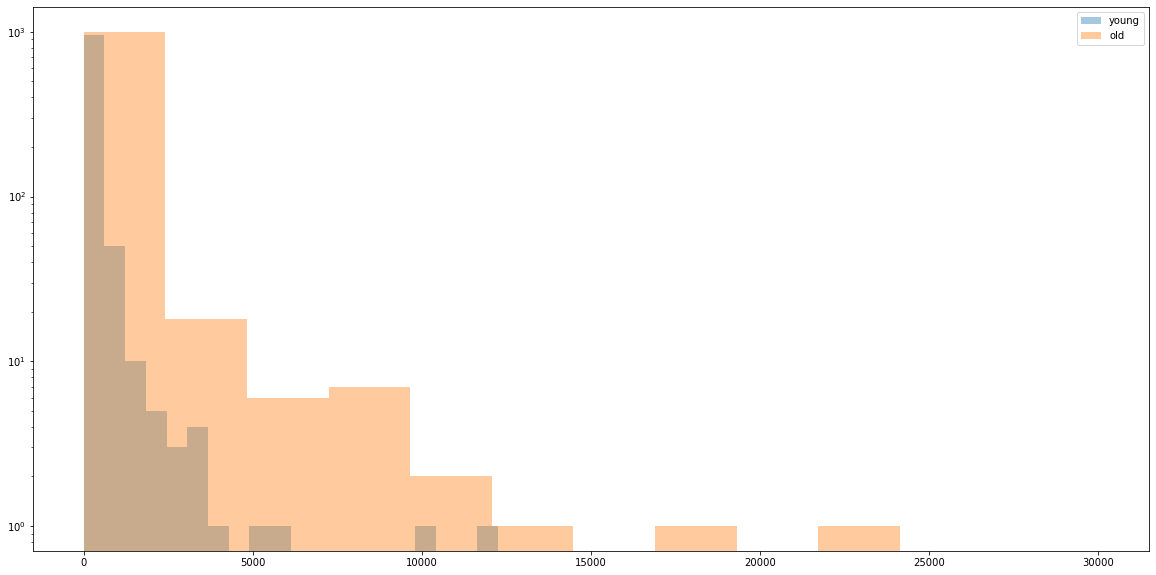

In [146]:
bins = np.linspace(0, 30000, 50)

plt.hist(young_train.VRDeck, bins, alpha=0.4, label='young')
plt.hist(old_train.VRDeck, alpha=0.4, label='old')
plt.legend(loc='upper right')
plt.yscale('log')
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

We discovered that kids (12 years or younger) does not spend any money. We also wanted to uncover whether there was some different spending habits between teens and seniors. This is what we uncovered:
- Seniors spend slightly more on FoodCourt and ALOT more on Spa and VRDeck
- Teens and seniors spend about the same on ShoppingMall and RoomService.

In [147]:
spendAny_train = train[(train["Age"] >= 13) & ((train["FoodCourt"] > 0) | (train["Spa"] > 0) | (train["VRDeck"] > 0) | (train["RoomService"] > 0) | (train["ShoppingMall"] > 0))]
spendNone_train = train[(train["Age"] >= 13) & ((train["FoodCourt"] == 0) & (train["Spa"] == 0) & (train["VRDeck"] == 0) & (train["RoomService"] == 0) & (train["ShoppingMall"] == 0))]
spendAll_train = train[(train["Age"] >= 13) & ((train["FoodCourt"] > 0) & (train["Spa"] > 0) & (train["VRDeck"] > 0) & (train["RoomService"] > 0) & (train["ShoppingMall"] > 0))]

spendAny_test = test[(test["Age"] >= 13) & ((test["FoodCourt"] > 0) | (test["Spa"] > 0) | (test["VRDeck"] > 0) | (test["RoomService"] > 0) | (test["ShoppingMall"] > 0))]
spendNone_test = test[(test["Age"] >= 13) & ((test["FoodCourt"] == 0) & (test["Spa"] == 0) & (test["VRDeck"] == 0) & (test["RoomService"] == 0) & (test["ShoppingMall"] == 0))]
spendAll_test = test[(test["Age"] >= 13) & ((test["FoodCourt"] > 0) & (test["Spa"] > 0) & (test["VRDeck"] > 0) & (test["RoomService"] > 0) & (test["ShoppingMall"] > 0))]

amt_adults = len(train) - len(kids_train)
print("Spent anything:", len(spendAny_train), "-", round(len(spendAny_train)/amt_adults*100,2),"%")
print("Spent nothing:", len(spendNone_train), "-", round(len(spendNone_train)/amt_adults*100,2),"%")
print("Spent on everything:", len(spendAll_train), "-", round(len(spendAll_train)/amt_adults*100,2),"%")
spendNone_train.shape

Spent anything: 4950 - 62.76 %
Spent nothing: 2449 - 31.05 %
Spent on everything: 249 - 3.16 %


(2449, 14)

In [148]:
cryo = spendNone_train[spendNone_train['CryoSleep'] == False]
len(cryo)

94

94 People who wasn't in cryosleep didn't spend money.

Text(0.5, 0, 'Age (years)')

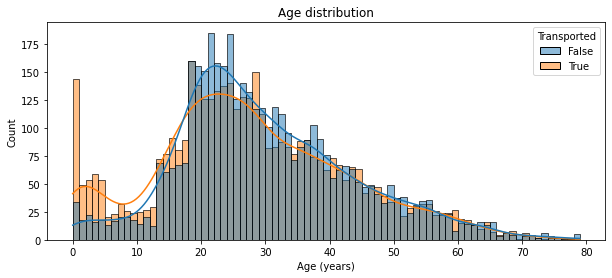

In [149]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

Seems like 18 year olds or younger have a higher chance of being transported than otherwise.

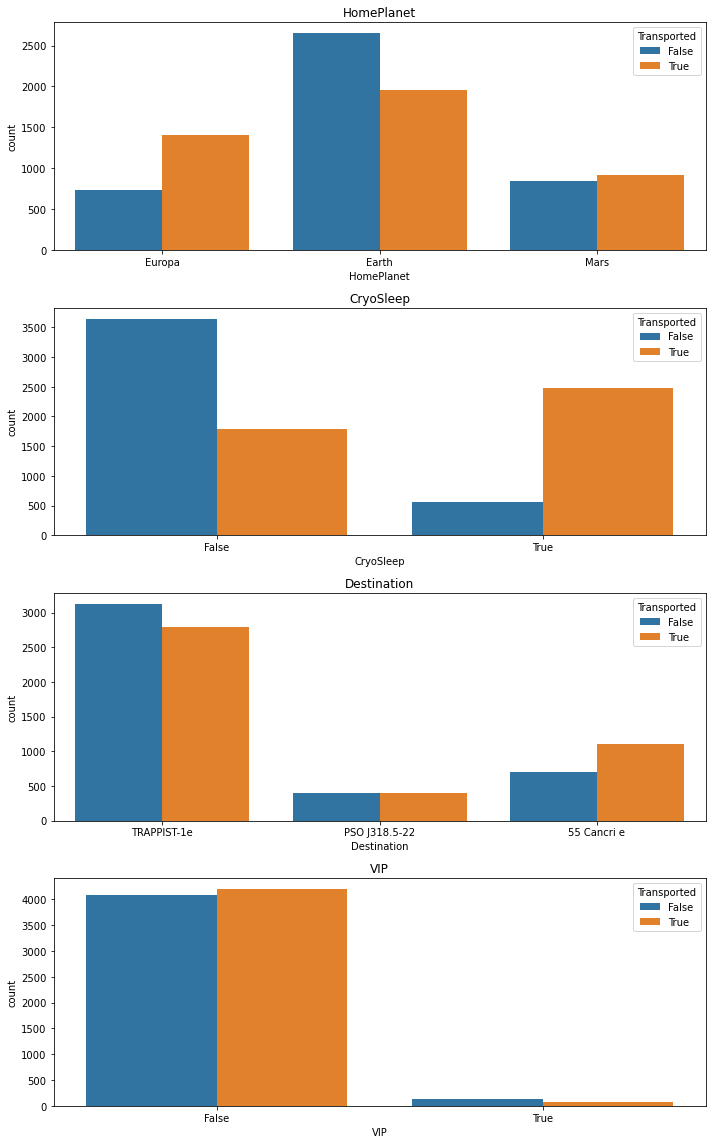

In [150]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

It seems like CryoSleep is an important feature. Cryosleeping passengers seem to be a target to be transported, while only 1/3 of the non-cryosleeping passengers is transported.

VIP Also doesn't really seem like an important feature.

# 4. Prepare the data to better expose the underlying data patterns to machine learning algorithms.
1. *Data cleaning:*
- *Fix or remove outliers (optional).*
- *Fill in missing values (e.g., with zero, mean, median…) or drop their rows (or columns).*
2. *Feature selection (optional):*
- *Drop the attributes that provide no useful information for the task.*
3. *Feature engineering, where appropriate:*
- *Discretize (approximate) continuous features.*
- *Decompose features (e.g., categorical, date/time, etc.).*
- *Add promising transformations of features (e.g., log(x), sqrt(x), x 2 , etc.).*
- *Aggregate features into promising new features.*
4. *Feature scaling:*
- *Standardize or normalize features.*

In [151]:
# Dealing the missing values of the CryoSleep feature.
# Set all cryosleep missing values of those who did not spend any money to true.
spendNone_train.loc[spendNone_train['CryoSleep'].isnull(), 'CryoSleep'] = True
spendNone_test.loc[spendNone_test['CryoSleep'].isnull(), 'CryoSleep'] = True

# Override train with new values from spendNone
train.update(spendNone_train)
test.update(spendNone_test)

# Fill the rest with the most common value, false
train['CryoSleep'].fillna(False, inplace = True)
test['CryoSleep'].fillna(False, inplace = True)

train['CryoSleep'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: CryoSleep
Non-Null Count  Dtype
--------------  -----
8693 non-null   bool 
dtypes: bool(1)
memory usage: 8.6 KB


In [152]:
# All null values for kids in the spending features should be 0.
kids_train.loc[kids_train['Spa'].isnull(), 'Spa'] = 0
kids_train.loc[kids_train['VRDeck'].isnull(), 'VRDeck'] = 0
kids_train.loc[kids_train['RoomService'].isnull(), 'RoomService'] = 0
kids_train.loc[kids_train['ShoppingMall'].isnull(), 'ShoppingMall'] = 0
kids_train.loc[kids_train['FoodCourt'].isnull(), 'FoodCourt'] = 0

kids_test.loc[kids_test['Spa'].isnull(), 'Spa'] = 0
kids_test.loc[kids_test['VRDeck'].isnull(), 'VRDeck'] = 0
kids_test.loc[kids_test['RoomService'].isnull(), 'RoomService'] = 0
kids_test.loc[kids_test['ShoppingMall'].isnull(), 'ShoppingMall'] = 0
kids_test.loc[kids_test['FoodCourt'].isnull(), 'FoodCourt'] = 0

# Override train with values from kids.
train.update(kids_train)
test.update(kids_test)

In [153]:
# We can do similar on the Spa and VRDeck, because they vary greatly on age.
old_train.loc[old_train['Spa'].isnull(), 'Spa'] = old_train['Spa'].median()
old_train.loc[old_train['VRDeck'].isnull(), 'VRDeck'] = old_train['VRDeck'].median()
old_test.loc[old_test['Spa'].isnull(), 'Spa'] = old_test['Spa'].median()
old_test.loc[old_test['VRDeck'].isnull(), 'VRDeck'] = old_test['VRDeck'].median()

young_train.loc[young_train['Spa'].isnull(), 'Spa'] = young_train['Spa'].median()
young_train.loc[young_train['VRDeck'].isnull(), 'VRDeck'] = young_train['VRDeck'].median()
young_test.loc[young_test['Spa'].isnull(), 'Spa'] = young_test['Spa'].median()
young_test.loc[young_test['VRDeck'].isnull(), 'VRDeck'] = young_test['VRDeck'].median()

# Override train with new values from the updated tables
train.update(young_train)
train.update(old_train)
test.update(young_test)
test.update(old_test)

# Fill the rest with the median, including ShoppingMall, RoomService and FoodCourt those that didnt really vary in terms of age.
train['Spa'].fillna(train['Spa'].median(), inplace = True)
train['VRDeck'].fillna(train['VRDeck'].median(), inplace = True)
train['ShoppingMall'].fillna(train['ShoppingMall'].median(), inplace = True)
train['RoomService'].fillna(train['RoomService'].median(), inplace = True)
train['FoodCourt'].fillna(train['FoodCourt'].median(), inplace = True)
test['Spa'].fillna(test['Spa'].median(), inplace = True)
test['VRDeck'].fillna(test['VRDeck'].median(), inplace = True)
test['ShoppingMall'].fillna(test['ShoppingMall'].median(), inplace = True)
test['RoomService'].fillna(test['RoomService'].median(), inplace = True)
test['FoodCourt'].fillna(test['FoodCourt'].median(), inplace = True)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 950.9+ KB


Now that were done with filling in the missing values for the money features, we can construct a new feature: TotalSpent

In [154]:
train['TotalSpent'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
test['TotalSpent'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

In [155]:
# For age were differentiating what we do with the null values wheter they spend or not. If they don't spend, were just setting their age to 0.
train.loc[(train['Age'].isnull()) & (train['TotalSpent'] == 0), 'Age'] = 0
test.loc[(test['Age'].isnull()) & (test['TotalSpent'] == 0), 'Age'] = 0

In [156]:
# And if they do, were just doing median age
train.loc[(train['Age'].isnull()) & (train['TotalSpent'] > 0), 'Age'] = train["Age"].median()
test.loc[(test['Age'].isnull()) & (test['TotalSpent'] > 0), 'Age'] = test["Age"].median()

In [157]:
train['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [158]:
# For missing VIP values were just gonna put false.
train['VIP'].fillna(False, inplace = True)
test['VIP'].fillna(False, inplace = True)

Now it becomes more tricky. It makes sense that each group would stay in the same cabin, travel to the same location and have the same lastname.
First lets contruct some new features to make filling in those missing values a bit easier.

In [159]:
# First lets spilt the ID and group into two new features Group And ID.
train[['Group','ID']] = train.PassengerId.str.split("_",expand=True)
test[['Group','ID']] = test.PassengerId.str.split("_",expand=True)

# Lets also make a new feature; lastname and drop the firstname feature.
train[['toDrop','LastName']] = train.Name.str.split(expand=True)
test[['toDrop','LastName']] = test.Name.str.split(expand=True)

train = train.drop(["toDrop"], axis=1)
train = train.drop(["Name"], axis=1)
test = test.drop(["toDrop"], axis=1)
test = test.drop(["Name"], axis=1)

Let's do the same for Cabins.

In [160]:
# Adds 3 new features, Deck, Number and Side.
train[['Deck','Number', 'Side']] = train.Cabin.str.split("/",expand=True)
test[['Deck','Number', 'Side']] = test.Cabin.str.split("/",expand=True)

# Dont need Cabin anymore
train = train.drop(["Cabin"], axis=1)
test = test.drop(["Cabin"], axis=1)

It will also be useful to know how many members each group has.
(The snippet below is from: 'Spaceship Titanic: A complete guide' by SAMUEL CORTINHAS)

In [161]:
# New feature - Group size
train['GroupSize']=train['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])
test['GroupSize']=test['Group'].map(lambda x: pd.concat([train['Group'], test['Group']]).value_counts()[x])

To fill the remaining values, we will combine the training and test set. This makes thing a lot easier.

In [162]:
targetY = train['Transported'].copy().astype(int)
X = train.drop('Transported', axis=1).copy()

data = pd.concat([X, test], axis=0).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12970 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12970 non-null  float64
 5   VIP           12970 non-null  bool   
 6   RoomService   12970 non-null  float64
 7   FoodCourt     12970 non-null  float64
 8   ShoppingMall  12970 non-null  float64
 9   Spa           12970 non-null  float64
 10  VRDeck        12970 non-null  float64
 11  TotalSpent    12970 non-null  float64
 12  Group         12970 non-null  object 
 13  ID            12970 non-null  object 
 14  LastName      12676 non-null  object 
 15  Deck          12671 non-null  object 
 16  Number        12671 non-null  object 
 17  Side          12671 non-null  object 
 18  GroupSize     12970 non-nu

In [163]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Transported   8693 non-null   object 
 12  TotalSpent    8693 non-null   float64
 13  Group         8693 non-null   object 
 14  ID            8693 non-null   object 
 15  LastName      8493 non-null   object 
 16  Deck          8494 non-null   object 
 17  Number        8494 non-null   object 
 18  Side          8494 non-null 

In [164]:
len(targetY)

8693

Let's find out if passengers in the same group stays on the same side.

Text(0.5, 1.0, 'Number of unique cabin sides per group')

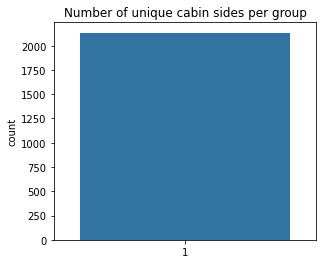

In [165]:
side_grouped = data[data['GroupSize']>1].groupby(['Group','Side'])['Side'].size().unstack().fillna(0)

fig=plt.figure(figsize=(16, 4))
plt.subplot(1,3,2)
sns.countplot((side_grouped>0).sum(axis=1))
plt.title('Number of unique cabin sides per group')

In [166]:
data['PassengerId'].nunique() 

12970

Every group stay on the same side. This makes it easy to fill values for passengers in groups where the the side is known.

In [167]:
missing_side = data.loc[(data['Side'].isna()) & (data['GroupSize'] > 1)]
for i in range(len(missing_side)) :
    for j in range(len(data)) :
        if((missing_side['Group'].iloc[i] == data['Group'].iloc[j])  & (isinstance(data['Side'].iloc[j], str))) :           
            missing_side['Side'].iloc[i] = data['Side'].iloc[j] 
            break

data.update(missing_side)
print("Remaining NaN values:",data['Side'].isna().sum())

Remaining NaN values: 162


Were down to 159 missing entries. Let's try to see if we can fill some more using LastName.

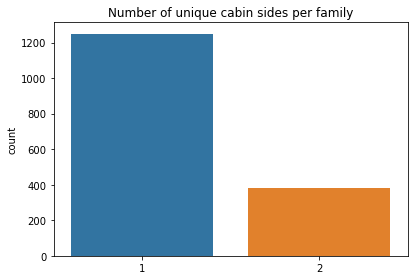

In [168]:
side_fam_grouped = data[data['GroupSize']>1].groupby(['LastName','Side'])['Side'].size().unstack().fillna(0)

fig=plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
sns.countplot((side_fam_grouped > 0).sum(axis=1))
plt.title('Number of unique cabin sides per family')
fig.tight_layout()

The vast majority of families stay on the same side. We will fill more values depending if they have a family member.

In [169]:
missing_side = data.loc[(data['Side'].isna())]
for i in range(len(missing_side)) :
    for j in range(len(data)) :
        if((missing_side['LastName'].iloc[i] == data['LastName'].iloc[j]) & (isinstance(data['Side'].iloc[j], str))) :           
            missing_side['Side'].iloc[i] = data['Side'].iloc[j] 
            break

data.update(missing_side)
data.loc[data['Side'].isna()].head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpent,Group,ID,LastName,Deck,Number,Side,GroupSize
462,0502_01,Mars,False,TRAPPIST-1e,22.0,False,10.0,0.0,817.0,471.0,0.0,1298.0,0502,01,Swell,NaN,NaN,NaN,1.0
1980,2117_01,Europa,False,TRAPPIST-1e,31.0,False,0.0,8718.0,0.0,13036.0,267.0,22021.0,2117,01,Rocketedy,NaN,NaN,NaN,1.0
3308,3553_01,Mars,False,TRAPPIST-1e,28.0,False,3.0,0.0,0.0,327.0,2054.0,2384.0,3553,01,Maie,NaN,NaN,NaN,1.0
6037,6385_01,Mars,False,PSO J318.5-22,21.0,False,435.0,0.0,422.0,16.0,0.0,873.0,6385,01,Duncy,NaN,NaN,NaN,1.0
10257,3367_01,Earth,False,TRAPPIST-1e,28.0,False,0.0,818.0,51.0,0.0,0.0,869.0,3367,01,NaN,NaN,NaN,NaN,1.0


Only five people does not have a side. Let's set those values to 'X' For now.

In [170]:
data.loc[data['Side'].isna(),'Side'] = 'X'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12970 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12970 non-null  float64
 5   VIP           12970 non-null  object 
 6   RoomService   12970 non-null  float64
 7   FoodCourt     12970 non-null  float64
 8   ShoppingMall  12970 non-null  float64
 9   Spa           12970 non-null  float64
 10  VRDeck        12970 non-null  float64
 11  TotalSpent    12970 non-null  float64
 12  Group         12970 non-null  object 
 13  ID            12970 non-null  object 
 14  LastName      12676 non-null  object 
 15  Deck          12671 non-null  object 
 16  Number        12671 non-null  object 
 17  Side          12970 non-null  object 
 18  GroupSize     12970 non-nu

In [171]:
data['PassengerId'].nunique() ## 12970

12970

Now we take care of the cabin decks.

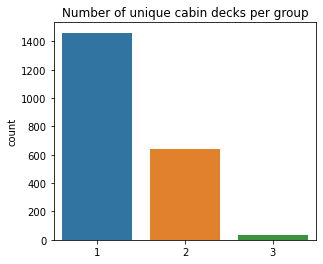

In [172]:
deck_grouped = data[data['GroupSize']>1].groupby(['Group','Deck'])['Deck'].size().unstack().fillna(0)

fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((deck_grouped>0).sum(axis=1))
plt.title('Number of unique cabin decks per group')
plt.show()

Let's try a similar approach as we did with the cabin sides. The figure above backs up the statement that most groups stay at the same deck.

In [173]:
missing_deck = data.loc[(data['Deck'].isna()) & (data['GroupSize'] > 1)]
for i in range(len(missing_deck)) :
    for j in range(len(data)) :
        if((missing_deck['Group'].iloc[i] == data['Group'].iloc[j])  & (isinstance(data['Deck'].iloc[j], str))) :           
            missing_deck['Deck'].iloc[i] = data['Deck'].iloc[j] 
            break

data.update(missing_deck)
data['Deck'].isna().sum()

162

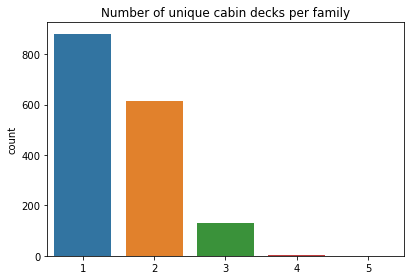

In [174]:
deck_fam_grouped = data[data['GroupSize']>1].groupby(['LastName','Deck'])['Deck'].size().unstack().fillna(0)

fig=plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
sns.countplot((deck_fam_grouped > 0).sum(axis=1))
plt.title('Number of unique cabin decks per family')
fig.tight_layout()

It appears that families are likely to stay on the same deck, but not by a lot. Let's see if we can use some other features like HomePlanet to see if one deck is more likely to house people from the same planet.

<AxesSubplot:xlabel='HomePlanet', ylabel='Deck'>

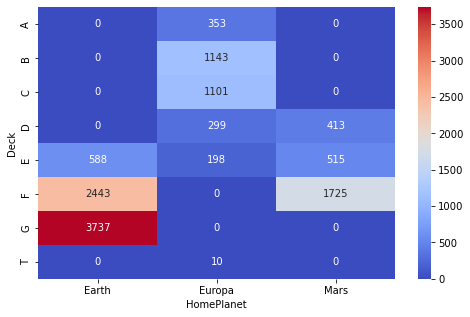

In [175]:
# Correlation between HomePlanet and Deck
home_deck = data.groupby(['HomePlanet','Deck'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize = (8,5))
sns.heatmap(home_deck.T, annot=True, fmt='g', cmap='coolwarm')

Seems like people from earth are more likely to be in deck G, F and E (in that order). People from Mars are likely to stay in F, G and D while Europa has people across all decks, but mostly in B and C. We will just put people from Earth and Mars into deck G and F respectivly. But Europa requires some further investigation.

In [176]:
# Passengers from Earth.
data.loc[(data['HomePlanet'] == 'Earth') & (data['Deck'].isna()), 'Deck'] = 'G'

# Passengers from Mars
data.loc[(data['HomePlanet'] == 'Mars') & (data['Deck'].isna()), 'Deck'] = 'F'
data['Deck'].isna().sum()

34

Now we want to find out wheater we put passengers from Europa in deck B or C.

<AxesSubplot:xlabel='CryoSleep', ylabel='Deck'>

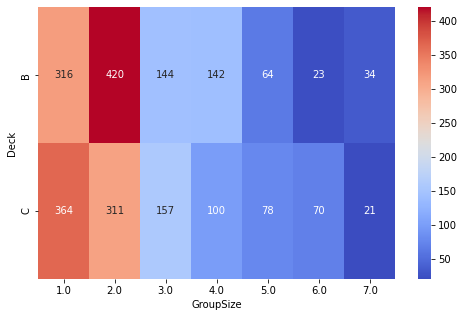

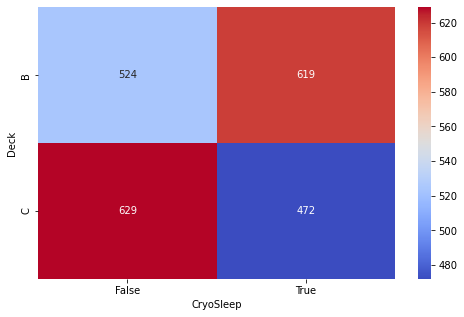

In [177]:
eur_deck_dest = data[(data["HomePlanet"] == "Europa") & ((data["Deck"] == "B") | (data["Deck"] == "C"))].groupby(['GroupSize','Deck'])['Deck'].size().unstack().fillna(0)
eur_deck_cryo = data[(data["HomePlanet"] == "Europa") & ((data["Deck"] == "B") | (data["Deck"] == "C"))].groupby(['CryoSleep','Deck'])['Deck'].size().unstack().fillna(0)

plt.figure(figsize = (8,5))
sns.heatmap(eur_deck_dest.T, annot=True, fmt='g', cmap='coolwarm')

plt.figure(figsize = (8,5))
sns.heatmap(eur_deck_cryo.T, annot=True, fmt='g', cmap='coolwarm')

After a bit of trial and error we found out that the two most reliable correlations were GroupSize and CryoSleep.

In [178]:
dataEur = data.loc[(data['HomePlanet'] == 'Europa') & (data['Deck'].isna())]

# If you are not cryosleeping you are likely to be in Deck C.
dataEur.loc[(data['CryoSleep'] == False), 'Deck'] = 'C'

# If you're cryosleeping you're likely to be in Deck B. 
dataEur.loc[(data['CryoSleep'] == True), 'Deck'] = 'B'

data.update(dataEur)
data.loc[data['Deck'].isna()].head(20)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpent,Group,ID,LastName,Deck,Number,Side,GroupSize
1550,1645_01,NaN,True,55 Cancri e,18.0,False,0.0,0.0,0.0,0.0,0.0,0.0,1645,01,Thonyderson,NaN,NaN,S,1.0
1714,1823_01,NaN,False,TRAPPIST-1e,67.0,False,143.0,68.0,496.0,182.0,9.0,898.0,1823,01,Byerson,NaN,NaN,P,1.0
3858,4134_01,NaN,True,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,0.0,0.0,4134,01,Datty,NaN,NaN,S,1.0
7293,7801_01,NaN,False,55 Cancri e,21.0,False,1720.0,2337.0,0.0,1.0,335.0,4393.0,7801,01,Coopezmaney,NaN,NaN,S,1.0
12114,7469_01,NaN,False,TRAPPIST-1e,24.0,False,433.0,110.0,209.0,23.0,0.0,775.0,7469,01,Baxterson,NaN,NaN,S,1.0


Now were only left with passengers who have NaN as HomePlanet as well as Deck. We'll set these to 'X'.

In [179]:
data.loc[data['Deck'].isna(),'Deck'] = 'X'
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12970 non-null  object 
 3   Destination   12696 non-null  object 
 4   Age           12970 non-null  float64
 5   VIP           12970 non-null  object 
 6   RoomService   12970 non-null  float64
 7   FoodCourt     12970 non-null  float64
 8   ShoppingMall  12970 non-null  float64
 9   Spa           12970 non-null  float64
 10  VRDeck        12970 non-null  float64
 11  TotalSpent    12970 non-null  float64
 12  Group         12970 non-null  object 
 13  ID            12970 non-null  object 
 14  LastName      12676 non-null  object 
 15  Deck          12970 non-null  object 
 16  Number        12671 non-null  object 
 17  Side          12970 non-null  object 
 18  GroupSize     12970 non-nu

**Final step of filling the Cabin spaces is the cabin number.**

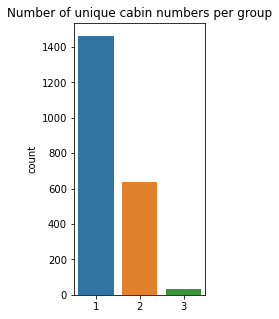

In [180]:
number_grouped = data[data['GroupSize']>1].groupby(['Group','Number'])['Number'].size().unstack().fillna(0)

plt.figure(figsize = (8,5))
plt.subplot(1,3,2)
sns.countplot((number_grouped > 0).sum(axis=1))
plt.title('Number of unique cabin numbers per group')
plt.show()

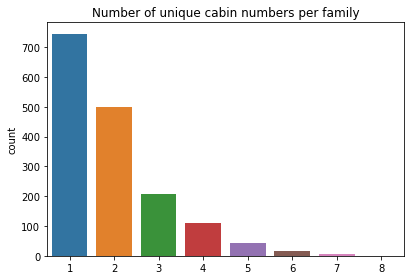

In [181]:
num_fam_grouped = data[data['GroupSize']>1].groupby(['LastName','Number'])['Number'].size().unstack().fillna(0)

fig=plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
sns.countplot((num_fam_grouped > 0).sum(axis=1))
plt.title('Number of unique cabin numbers per family')
fig.tight_layout()

As with deck, we're not confident in setting the cabin number the same as the passengers with the same last name. In 'Spaceship Titanic: A complete guide' there is a great idea to predict the number using linear regression. The next two snippets is inspired by that solution.

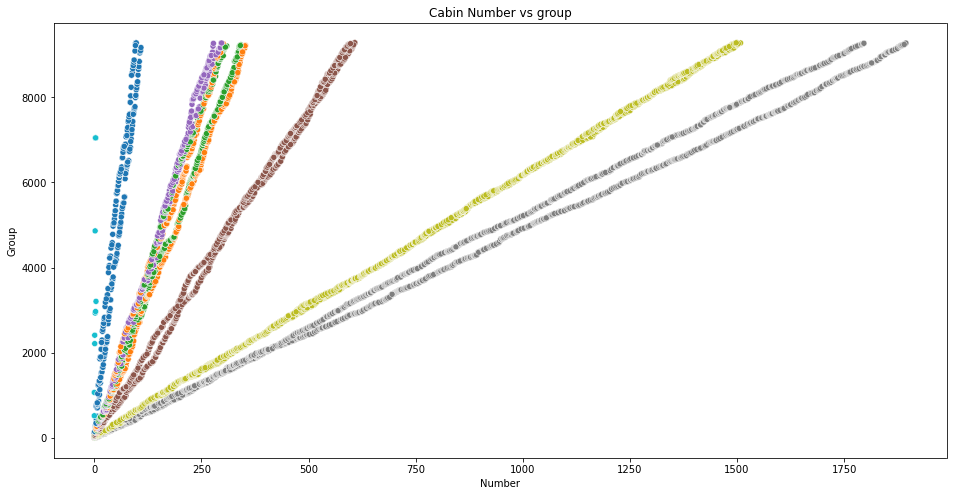

In [182]:
x=data.loc[data['Number'].notnull(), 'Number']
y=data['Group']
x = x.astype(int)
y = y.astype(int)

plt.figure(figsize=(16,8))
sns.scatterplot(x, y, c=LabelEncoder().fit_transform(data.loc[~data['Number'].isna(),'Deck']), cmap='tab10')
plt.title('Cabin Number vs group')
plt.show()

The idea is that the cabin numbers follows a seemingly linear pattern on a deck-by-deck basis. We can use this to predict the value of the missing values by using linear regression.

In [183]:
# Extrapolate linear relationship on a deck by deck basis
for deck in ['A', 'B', 'C', 'D', 'E', 'F', 'G']:
    # Creating training set and test set
    X = data.loc[~(data['Number'].isna()) & (data['Deck']==deck),'Group']
    y = data.loc[~(data['Number'].isna()) & (data['Deck']==deck),'Number']
    X_test = data.loc[(data['Number'].isna()) & (data['Deck']==deck),'Group']

    if (len(X_test) > 0) :
        # Linear regression
        model_CN = LinearRegression()
        model_CN.fit(X.values.reshape(-1, 1), y)
        pred=model_CN.predict(X_test.values.reshape(-1, 1))
    
        # Fill in the missing values
        data.loc[(data['Number'].isna()) & (data['Deck']==deck),'Number']=pred.astype(int)

# Fill those who has Number as Null to -1.
data.loc[data['Number'].isna(), 'Number'] = -1

In [184]:
data['PassengerId'].nunique()

12970

Now lets figure out how to fill the Homeplanets.

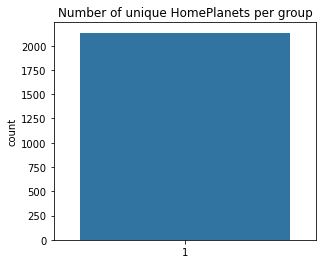

In [185]:
HomePlanet_grouped = data[data['GroupSize']>1].groupby(['Group','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((HomePlanet_grouped>0).sum(axis=1))
plt.title('Number of unique HomePlanets per group')
plt.show()

Almost every group comes from the same homeplanet. Let's fill those in by group members as before. We can also fill in according to LastName, because no same lastname occurs on different planets.

In [186]:
missing_hp = data.loc[data['HomePlanet'].isna()]

for i in range(len(missing_hp)) :
    for j in range(len(data)) :
        if(((missing_hp['Group'].iloc[i] == data['Group'].iloc[j]) | (missing_hp['LastName'].iloc[i] == data['LastName'].iloc[j])) & (isinstance(data['HomePlanet'].iloc[j], str))) :           
            missing_hp['HomePlanet'].iloc[i] = data['HomePlanet'].iloc[j] 
            break

data.update(missing_hp)
data['HomePlanet'].isna().sum()

13

We can fill the remaining few by just imputing according to deck.

<AxesSubplot:xlabel='HomePlanet', ylabel='Deck'>

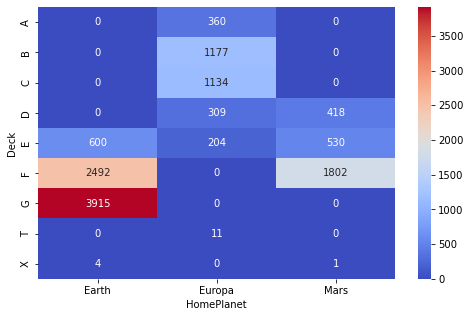

In [187]:
# Correlation between HomePlanet and Deck
home_deck = data.groupby(['HomePlanet','Deck'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize = (8,5))
sns.heatmap(home_deck.T, annot=True, fmt='g', cmap='coolwarm')

In [188]:
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'A'),'HomePlanet'] = 'Europa'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'B'),'HomePlanet'] = 'Europa'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'C'),'HomePlanet'] = 'Europa'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'G'),'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'T'),'HomePlanet'] = 'Europa'
data.loc[data['HomePlanet'].isna()].head(10)

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpent,Group,ID,LastName,Deck,Number,Side,GroupSize
2274,2443_01,NaN,False,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,0.0,0.0,1955.0,2443,01,NaN,D,72,P,1.0
2631,2817_01,NaN,False,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,0.0,12.0,1159.0,2817,01,Sutty,F,584,P,1.0
3091,3331_01,NaN,False,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,0.0,50.0,803.0,3331,01,NaN,F,631,S,1.0
4548,4840_01,NaN,True,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,0.0,0.0,0.0,4840,01,NaN,F,915,S,1.0
5762,6108_01,NaN,False,TRAPPIST-1e,13.0,False,206.0,28.0,0.0,1.0,629.0,864.0,6108,01,NaN,F,1166,S,1.0
8969,0616_01,NaN,False,TRAPPIST-1e,31.0,False,0.0,428.0,0.0,1154.0,1025.0,2607.0,0616,01,Spriney,E,40,S,1.0
10583,4052_01,NaN,False,TRAPPIST-1e,26.0,False,6.0,5903.0,0.0,240.0,72.0,6221.0,4052,01,Coneveseng,D,136,P,1.0
11913,7065_01,NaN,True,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,0.0,0.0,7065,01,Maltorted,E,471,S,1.0
12551,8435_01,NaN,False,TRAPPIST-1e,19.0,False,162.0,11.0,0.0,0.0,1216.0,1389.0,8435,01,NaN,F,1730,P,1.0
12725,8775_01,NaN,True,TRAPPIST-1e,40.0,False,0.0,0.0,0.0,0.0,0.0,0.0,8775,01,Maltorted,D,275,P,1.0


Only passengers heading to Trappist-1e left, lets check correlation between those heading there and homeplanet.

<AxesSubplot:xlabel='HomePlanet', ylabel='Destination'>

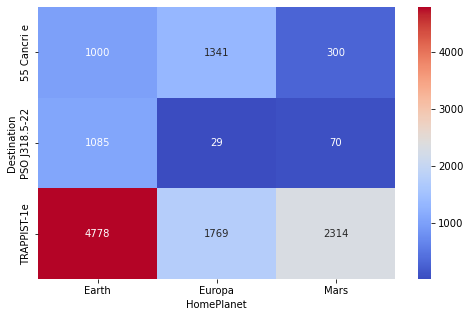

In [189]:
# Correlation between HomePlanet and Deck
home_deck = data.groupby(['HomePlanet','Destination'])['HomePlanet'].size().unstack().fillna(0)

plt.figure(figsize = (8,5))
sns.heatmap(home_deck.T, annot=True, fmt='g', cmap='coolwarm')

We're missing deck D, E and F, And we see that Trappist-1e is the most common destination for everyone. Still we can see thats it's likely that.
- Passengers from Deck D and heading to Trappist-1e is likely Martians.
- Passengers from Deck E and heading to Trappist-1e is likely Earthlings.
- Passengers from Deck F and heading to Trappist-1e is likely Earthlings.

We'll just set accoring to deck for simplicity and reproducabilities sake.

In [190]:
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'D'),'HomePlanet'] = 'Mars'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'E'),'HomePlanet'] = 'Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Deck'] == 'F'),'HomePlanet'] = 'Earth'

Now let's do the destination.

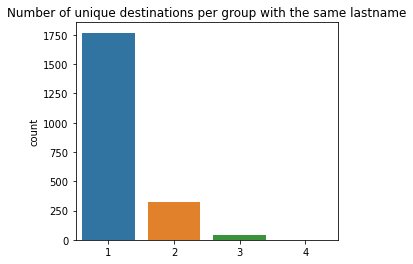

In [191]:
Destination_grouped = data[data['GroupSize']>1].groupby(['Group','LastName'])['LastName'].size().unstack().fillna(0)

fig=plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.countplot((Destination_grouped>0).sum(axis=1))
plt.title('Number of unique destinations per group with the same lastname')
plt.show()

Seems like there a great probability that passengers in groups with the same lastname travel to the same location. We won't really fill a lot of the missing values by using this, but at least it's some.

In [192]:
missing_dest = data.loc[(data['Destination'].isna()) & (data['GroupSize'] > 1)]
for i in range(len(missing_dest)) :
    for j in range(len(data)) :
        if((missing_dest['Group'].iloc[i] == data['Group'].iloc[j]) & (missing_dest['LastName'].iloc[i] == data['LastName'].iloc[j]) & (isinstance(data['Destination'].iloc[j], str))) :           
            missing_dest['Destination'].iloc[i] = data['Destination'].iloc[j]
            break

data.update(missing_dest)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  object 
 3   Destination   12802 non-null  object 
 4   Age           12970 non-null  float64
 5   VIP           12970 non-null  object 
 6   RoomService   12970 non-null  float64
 7   FoodCourt     12970 non-null  float64
 8   ShoppingMall  12970 non-null  float64
 9   Spa           12970 non-null  float64
 10  VRDeck        12970 non-null  float64
 11  TotalSpent    12970 non-null  float64
 12  Group         12970 non-null  object 
 13  ID            12970 non-null  object 
 14  LastName      12676 non-null  object 
 15  Deck          12970 non-null  object 
 16  Number        12970 non-null  object 
 17  Side          12970 non-null  object 
 18  GroupSize     12970 non-nu

About 100 values was overwritten. 

We've spent a fair amount of time checking if there is some other way we can impute correct destinations, but there doesn't seem to exist any great correlation to destination. Lets just impute the rest as Trappist-1e.

In [193]:
data.loc[(data['Destination'].isna()), 'Destination']='TRAPPIST-1e' 

LastName has done it's job by computing other features so we can safely drop it.

In [194]:
data = data.drop(["LastName"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12970 non-null  object 
 2   CryoSleep     12970 non-null  object 
 3   Destination   12970 non-null  object 
 4   Age           12970 non-null  float64
 5   VIP           12970 non-null  object 
 6   RoomService   12970 non-null  float64
 7   FoodCourt     12970 non-null  float64
 8   ShoppingMall  12970 non-null  float64
 9   Spa           12970 non-null  float64
 10  VRDeck        12970 non-null  float64
 11  TotalSpent    12970 non-null  float64
 12  Group         12970 non-null  object 
 13  ID            12970 non-null  object 
 14  Deck          12970 non-null  object 
 15  Number        12970 non-null  object 
 16  Side          12970 non-null  object 
 17  GroupSize     12970 non-null  float64
dtypes: float64(8), object(10)


And now we have 0 missing values!

Before we combine into test and training sets, lets bin cabin numbers into groups so we can drop it. We want to do this to reduce cardinality.

In [195]:
data['CabinsOutliers']=(data['Number'].astype(int)==-1).astype(int)
data['Cabins0-199']=((data['Number'].astype(int)>=0) & (data['Number'].astype(int)<200)).astype(int)
data['Cabins200-399']=((data['Number'].astype(int)>=200) & (data['Number'].astype(int)<400)).astype(int)
data['Cabins400-599']=((data['Number'].astype(int)>=400) & (data['Number'].astype(int)<600)).astype(int)
data['Cabins600-799']=((data['Number'].astype(int)>=600) & (data['Number'].astype(int)<800)).astype(int)
data['Cabins800-999']=((data['Number'].astype(int)>=700) & (data['Number'].astype(int)<1000)).astype(int)
data['Cabins1000-1199']=((data['Number'].astype(int)>=1000) & (data['Number'].astype(int)<1200)).astype(int)
data['Cabins1200-1399']=((data['Number'].astype(int)>=1200) & (data['Number'].astype(int)<1400)).astype(int)
data['Cabins1400-1599']=((data['Number'].astype(int)>=1400) & (data['Number'].astype(int)<1600)).astype(int)
data['Cabins1600-1799']=((data['Number'].astype(int)>=1600) & (data['Number'].astype(int)<1800)).astype(int)
data['Cabins1800-2000']=(data['Number'].astype(int)>=1800).astype(int)

In [196]:
data = data.drop(["Number"], axis=1)

Let's split the data again.

In [197]:
# Train and test
train = data[data['PassengerId'].isin(train['PassengerId'].values)].copy()
train['Transported'] = targetY
test = data[data['PassengerId'].isin(test['PassengerId'].values)].copy()

In [198]:
print("Cabin outliers in training set:", (train.loc[train['CabinsOutliers']==1].value_counts().sum())) 
print("Side outliers in training set:", (train.loc[train['Side']=='X'].value_counts().sum())) 
print("Cabin outliers in test set:", (test.loc[test['CabinsOutliers']==1].value_counts().sum())) 
print("Side outliers in test set:", (test.loc[test['Side']=='X'].value_counts().sum())) 

Cabin outliers in training set: 4
Side outliers in training set: 4
Cabin outliers in test set: 1
Side outliers in test set: 1


Because the outlier are all in the training set, were just gonna drop them. There is an outlier on cabin side in the testset and were to afraid to mess with it, so were just gonna leave it as is. Were also dropping the PassengerId seeing as we only needed it to split and combine the training/test set.

In [199]:
# Dropping the rows
train = train.loc[train['CabinsOutliers'] == 0]

# Dropping the outlier cabin column from the test and training set
train = train.drop(["CabinsOutliers", "PassengerId"], axis=1)
test = test.drop(["CabinsOutliers", "PassengerId"], axis=1)

Now were almost done with data exploration. Just need to encode and transform!

#### Encoding
We decieded to go with OneHotEncoder and make_column_tranformer to encode the columns.

Lets also rename the columns for VIP and Cryosleep cause its not really intuitive.

In [200]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['HomePlanet','CryoSleep','Destination','VIP','Deck','Side']), remainder='passthrough')

transformed = transformer.fit_transform(train)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())
train = transformed_df.astype(float)

transformed = transformer.fit_transform(test)
transformed_df_test = pd.DataFrame(transformed, columns=transformer.get_feature_names())
test = transformed_df_test.astype(float)

train.rename(columns={'onehotencoder__x1_False': 'cryosleep_false',
'onehotencoder__x1_True': 'cryosleep_true',
'onehotencoder__x3_False': 'VIP_false',
'onehotencoder__x3_True': 'VIP_true'}, inplace=True, errors='raise')

test.rename(columns={'onehotencoder__x1_False': 'cryosleep_false',
'onehotencoder__x1_True': 'cryosleep_true',
'onehotencoder__x3_False': 'VIP_false',
'onehotencoder__x3_True': 'VIP_true'}, inplace=True, errors='raise')

Splitting the data into training and validation sets. We have the target stored as targetY from when we concatinated the train and test data.

In [201]:
X = train.drop(['Transported'], axis=1)
y = train['Transported']

In [202]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

Scaling the data.

In [203]:
std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_val_std = std.fit_transform(X_val) 

# 5. Explore many different models and short-list the best ones
1. *Train many quick-and-dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forest, neural net, etc.) using standard parameters.*
2. *Measure and compare their performance.
(For each model, use N-fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.)*
3. *Analyze the most significant variables for each algorithm.*
4. *Analyze the types of errors the models make.
(What data would a human have used to avoid these errors?)*
5. *Perform a quick round of feature selection and engineering.*
6. *Perform one or two more quick iterations of the five previous steps.*
7. *Shortlist the top three to five most promising models, preferring models that make different types of errors.*

### Creating training and validation sets

Scaling data for the models that needs it.

In [204]:
# Random state for reproducability
rndState = 20

# Create an array of models
models = []
# models.append(('LR', LogisticRegression(random_state = rndState)))
# models.append(('SGD', SGDClassifier(random_state = rndState)))
# models.append(('GNB', GaussianNB()))
# models.append(('KNN', KNeighborsClassifier()))
models.append(('CATB', CatBoostClassifier(random_state = rndState, verbose = False)))
models.append(('LGBM', lgb.LGBMClassifier(random_state = rndState)))
# models.append(('XGB', xgb.XGBClassifier(random_state = rndState)))
models.append(('RFC', RandomForestClassifier(random_state = rndState)))
models.append(('GBC', GradientBoostingClassifier(random_state = rndState)))
# models.append(('SVC', svc(random_state = rndState)))
# models.append(('DT', DecisionTreeClassifier(random_state = rndState)))


CATB: 0.812458 (0.012534)


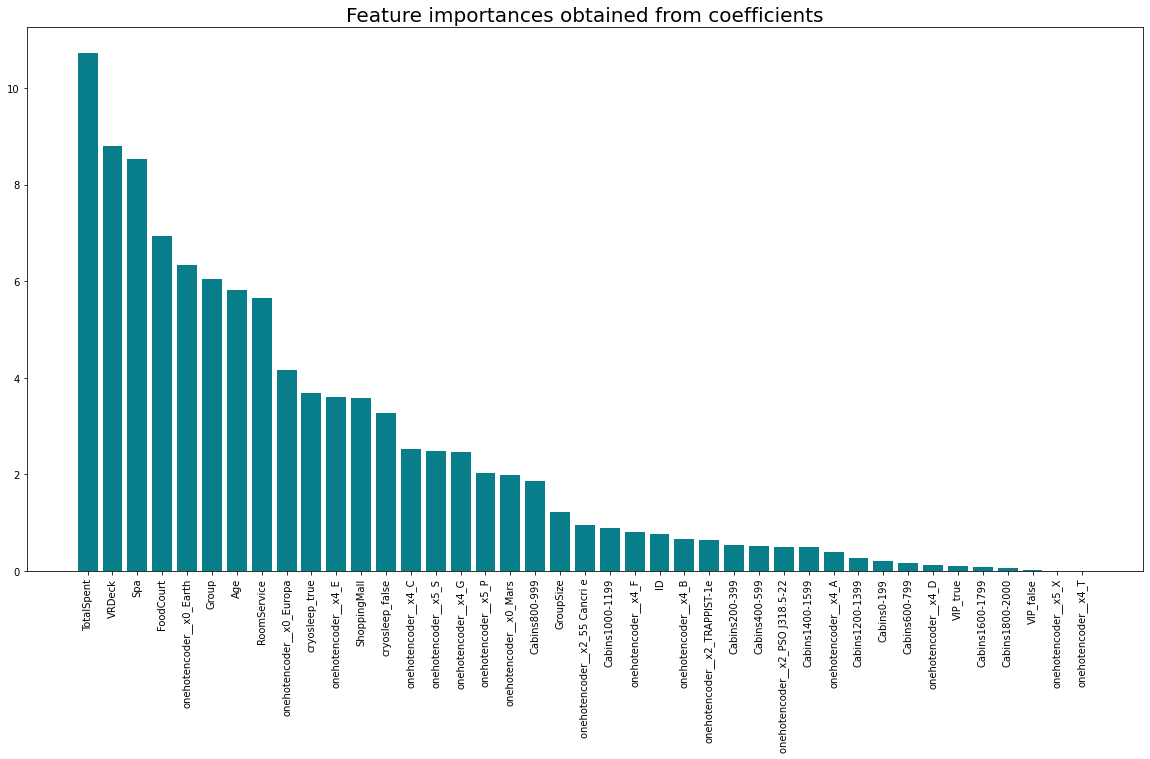

LGBM: 0.809391 (0.011399)


NotFittedError: No feature_importances found. Need to call fit beforehand.

In [210]:
results = []
names = []
scoring = 'accuracy'
seed = 10

# Scoring each model individually
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	if name == 'SGD' :
		cv_results = model_selection.cross_val_score(model, X_train_std, y_train, cv=kfold, scoring=scoring)
	else :
		cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

	# get importance
	model.fit(X_train, y_train)
	importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.feature_importances_
	})
	importances = importances.sort_values(by='Importance', ascending=False)
	plt.figure(figsize=(10, 10))
	plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
	plt.title('Feature importances obtained from coefficients (${name})', size=20)
	plt.xticks(rotation='vertical')
	plt.show()



Based on the results we continue with CATB, LGBM and GBC. Even though XGB scored well, it's a slow model and produces similar results to XGB.

In [209]:
model.feature.imporances_

AttributeError: 'CatBoostClassifier' object has no attribute 'feature'

In [207]:
print(importance)

None


In [ ]:
Boost_params = {'learning_rate': [0.05, 0.08, 0.1],
                'n_estimators' : [100, 200, 300, 400, 500],
                'depth'        : [7, 8, 9, 10]}

GBC_params = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": [5,7,9],
    "min_samples_leaf": [3,5,6],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[300, 400, 500]}

RF_params = {'n_estimators': [200, 250, 300, 400, 500],
             'max_depth'   : [8, 12, 14, 16]}

for name, model in models :

    start = time.time()
    if name == 'RFC' :
        clf = GridSearchCV(estimator=model, param_grid=RF_params, n_jobs=-1, cv=None)
    elif name == 'GBC':
        clf = GridSearchCV(estimator=model, param_grid=GBC_params, n_jobs=-1, cv=None)
    else :
        clf = GridSearchCV(estimator=model, param_grid=Boost_params, n_jobs=-1, cv=None)

    clf.fit(X_train, y_train)
    val_scores = clf.score(X_val, y_val)   

    stop = time.time()
    training_time = np.round((stop - start)/60, 2)
    
    msg = "%s: %f (%f min) %s" % (name, val_scores, training_time, clf.best_params_)
    print(msg)

- CATB: 0.815556 (49.090000 min) {'depth': 7, 'learning_rate': 0.05, 'n_estimators': 300}
- LGBM: 0.806222 (3.130000 min) {'depth': 6, 'learning_rate': 0.05, 'n_estimators': 200}
- RFC: 0.796889 (2.400000 min) {'max_depth': 12, 'n_estimators': 300}

Dropping XGBoost cause it's pretty similar to LGBM. If RFC makes mistakes different too LGBM and CATB were keeping that. Same goes with GBC.


# 6. Fine-tune your models and combine them into a great solution
1. Fine-tune the hyperparameters using cross-validation:
- Treat your data transformation choices as hyperparameters, especially when you are not sure about them (e.g., if you’re not sure whether to replace missing values with zeros or with the median value, or to just drop the rows).
- Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach (e.g., using Gaussian process priors, as described by Jasper Snoek et al.)
2. Try Ensemble methods. Combining your best models will often produce better performance than running them individually.

3. Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.

# 7. Present your solution
1. *Document what you have done.*
2. *Create a nice presentation.
(Make sure you highlight the big picture first.)*
3. *Explain why your solution achieves the business objective.*
4. *Don’t forget to present interesting points you noticed along the way.
(Describe what worked and what did not.)*
5. *Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g., “the median income is the number-one predictor of housing prices”).*

# 8. Launch, monitor, and maintain your system
1. *Get your solution ready for production (plug into production data inputs, write unit tests, etc.).*
2. *Write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops.*
- *Beware of slow degradation: models tend to “rot” as data evolves.*
- *Measuring performance may require a human pipeline (e.g., via a crowdsourcing service).*
- *Also monitor your inputs’ quality (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale). This is particularly important for online learning systems.*
3. *Retrain your models on a regular basis on fresh data (automate as much as possible).*